# 2 - Volume Analysis
In this section, we focus on the pools' 24H volume trend. Both time and frequency domain techniques will be used. Hourly volume analysis may be added in the future.

In [1]:
# Standard Library
import math
import os

# Third Party Library
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.pyplot import MaxNLocator

# Local Folder Library
from pyammanalysis.util import read_yaml

In [4]:
# config
config = read_yaml("../config.yaml")
SUBPLOTS_PER_ROW = config["SUBPLOTS_PER_ROW"]

# data folder paths
DATA_PATH = "data"

pools_df = pd.read_csv(os.path.join(DATA_PATH, "pools_df.csv"))
pool_names = pools_df["name"]

pool_day_df = pd.read_csv(
    os.path.join(DATA_PATH, "pool_day_df.csv"), parse_dates=["date"]
)

## Time Domain
### Time Trend

KeyError: 'USDC_WETH_500_volumeUSD'

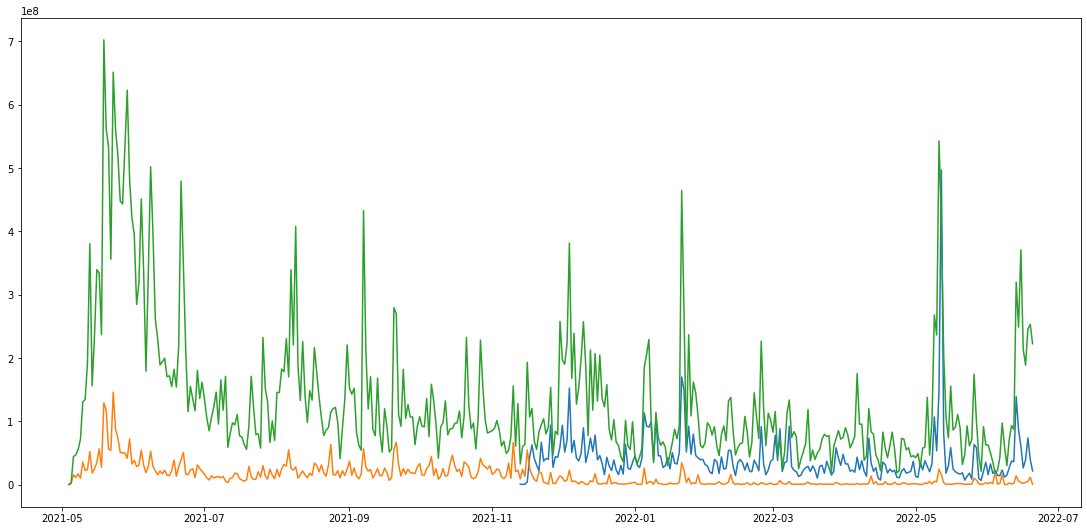

In [5]:
plt.figure(figsize=(19, 9))
for pool_name in pool_names:
    plt.plot(pool_day_df["date"], pool_day_df[pool_name + "_volumeUSD"])
plt.title("24H Volume over Time")
plt.xlabel("date")
plt.ylabel("24H Volume (in USD)")
plt.legend(pool_names, loc="upper left")
plt.show()

In [ ]:
# find the days with the greatest 24H volumes
# df.sort_values(by="volumeUSD", ascending=False)[:10]

In [ ]:
# # for reference only, no use now
# fig, ax = plt.subplots(figsize=(15, 1))
# sns.boxplot(data=df, x="volumeUSD")
# plt.xlim(0, 2e8)
# plt.show()

### Histogram
Observe the distribution of the prices.

In [ ]:
fig = plt.figure(figsize=(24, 16))
axes = fig.subplots(4, SUBPLOTS_PER_ROW)
for i, pool_name in enumerate(pool_names):
    volumeUSD_series = pool_day_df[pool_name + "_volumeUSD"]
    ax = axes[math.floor(i / SUBPLOTS_PER_ROW), i % SUBPLOTS_PER_ROW]
    ax.title.set_text(pool_name)
    ax.hist(volumeUSD_series, bins=100, range=(0, volumeUSD_series.quantile(0.99)))

    # force y-axis ticks to use integers
    ax.get_yaxis().set_major_locator(MaxNLocator(integer=True))

    # highlight 25%-75% percentile
    lq = volumeUSD_series.quantile(0.25)
    uq = volumeUSD_series.quantile(0.75)
    ax.axvspan(lq, uq, color="green", alpha=0.25)

fig.suptitle("24H Volume Distributions")
fig.supxlabel("24H Volume (in USD)")
plt.show()

In [ ]:
pool_df = pool_day_df.drop(columns="timestamp")
# note: df.std() is normalized by N-1
pool_metrics_df = pd.DataFrame(
    data=[pool_df.mean(), pool_df.std()], index=["mean", "stdev"]
)
pool_metrics_df

In [ ]:
# # for reference only, no use now
# df["volumeUSD"].plot.kde()
# plt.title(pool_name + " 24H Volume KDE")
# plt.xlim(0, 2e8)
# plt.show()

In [ ]:
# TODO: time series / autocorelation
# TODO: aggregate weekly and daily patterns and look for anomalies (e.g. Friday)
# TODO: ask for calculation of Greeks (Detla, Vega...)

## Frequency Domain
### Fast Fourier Transform (FFT)
FFT computes the frequency content of the prices as signals.

In [ ]:
fig = plt.figure(figsize=(24, 16))
axes = fig.subplots(4, SUBPLOTS_PER_ROW)
for i, pool_name in enumerate(pool_names):
    date_volume_df = pool_day_df[["date", pool_name + "_volumeUSD"]].dropna()
    volumeUSD_series = date_volume_df[pool_name + "_volumeUSD"]

    # reference for zero-mean signal:
    # https://dsp.stackexchange.com/questions/46950/removing-mean-from-signal-massively-distorts-fft
    # only keep those with freq STRICTLY > 0
    f_max = math.ceil(date_volume_df.shape[0] / 2)
    Y = abs(np.fft.fft(volumeUSD_series - volumeUSD_series.mean()))[1:f_max]
    freq = np.fft.fftfreq(date_volume_df.shape[0], 1)[1:f_max]

    ax = axes[math.floor(i / SUBPLOTS_PER_ROW), i % SUBPLOTS_PER_ROW]
    ax.title.set_text(pool_name)
    ax.plot(freq, Y)

fig.suptitle("24H Volume FFT")
fig.supxlabel("freq (in /day)")
fig.supylabel("24H Volume (in USD)")
plt.show()

In [ ]:
fig = plt.figure(figsize=(24, 16))
axes = fig.subplots(4, SUBPLOTS_PER_ROW)
for i, pool_name in enumerate(pool_names):
    date_volume_df = pool_day_df[["date", pool_name + "_volumeUSD"]].dropna()
    volumeUSD_series = date_volume_df[pool_name + "_volumeUSD"]

    # reference for zero-mean signal:
    # https://dsp.stackexchange.com/questions/46950/removing-mean-from-signal-massively-distorts-fft
    # only keep those with freq STRICTLY > 0
    f_max = math.ceil(date_volume_df.shape[0] / 2)
    Y = abs(np.fft.fft(volumeUSD_series - volumeUSD_series.mean()))[1:f_max]
    freq = np.fft.fftfreq(date_volume_df.shape[0], 1)[1:f_max]

    # c.f. power spectral density in signal processing
    spectrum = Y.real * Y.real + Y.imag * Y.imag

    ax = axes[math.floor(i / SUBPLOTS_PER_ROW), i % SUBPLOTS_PER_ROW]
    ax.title.set_text(pool_name)
    ax.set_xlim(left=freq[1], right=freq[-1])

    # Note: this is possible because FFT must give positive values,
    # so that their logarithms always exist.
    # plot log10(spectrum) against frequency
    ax.semilogy(freq, spectrum)

fig.suptitle("Semilog Plot of 24H Volume FFT")
fig.supxlabel("freq (in /day)")
fig.supylabel("Magnitude")
plt.show()